# Import Library

In [60]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib.ticker as mtick
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.pipeline import Pipeline
from scipy.stats import chi2_contingency
from sklearn.feature_selection import f_classif
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.decomposition import PCA
%matplotlib inline


print('numpy version : ',np.__version__)
print('pandas version : ',pd.__version__)
print('seaborn version : ',sns.__version__)

numpy version :  1.24.3
pandas version :  1.5.3
seaborn version :  0.12.2


# Basic Understanding of The Data

In [61]:
df = pd.read_csv('Clicked Ads Dataset.csv')
df.head()

,Unnamed: 0,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Male,Timestamp,Clicked on Ad,city,province,category
0,0,68.95,35,432837300.0,256.09,Perempuan,3/27/2016 0:53,No,Jakarta Timur,Daerah Khusus Ibukota Jakarta,Furniture
1,1,80.23,31,479092950.0,193.77,Laki-Laki,4/4/2016 1:39,No,Denpasar,Bali,Food
2,2,69.47,26,418501580.0,236.50,Perempuan,3/13/2016 20:35,No,Surabaya,Jawa Timur,Electronic
3,3,74.15,29,383643260.0,245.89,Laki-Laki,1/10/2016 2:31,No,Batam,Kepulauan Riau,House
4,4,68.37,35,517229930.0,225.58,Perempuan,6/3/2016 3:36,No,Medan,Sumatra Utara,Finance


In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                1000 non-null   int64  
 1   Daily Time Spent on Site  987 non-null    float64
 2   Age                       1000 non-null   int64  
 3   Area Income               987 non-null    float64
 4   Daily Internet Usage      989 non-null    float64
 5   Male                      997 non-null    object 
 6   Timestamp                 1000 non-null   object 
 7   Clicked on Ad             1000 non-null   object 
 8   city                      1000 non-null   object 
 9   province                  1000 non-null   object 
 10  category                  1000 non-null   object 
dtypes: float64(3), int64(2), object(6)
memory usage: 86.1+ KB


In [63]:
df.shape

(1000, 11)

Hasil `df.shape` menunjukkan bahwa DataFrame `df` memiliki 1000 baris dan 11 kolom. Ini berarti DataFrame tersebut terdiri dari 1000 data (baris) dan 11 fitur (kolom).

## Data Exploration

In [64]:
nums = []
cats = []

for col in df:
    if df[col].dtypes in ['int64','float64']:
        nums.append(col)
    else:
        cats.append(col)
        
nums_count = len(nums)
cats_count = len(cats)

print('Number of numerical columns:', nums_count)
print('Number of categorical columns:', cats_count)
print('-' * 70)
print('Numerical columns:', nums)
print('Categorical columns:', cats)

Number of numerical columns: 5
Number of categorical columns: 6
----------------------------------------------------------------------
Numerical columns: ['Unnamed: 0', 'Daily Time Spent on Site', 'Age', 'Area Income', 'Daily Internet Usage']
Categorical columns: ['Male', 'Timestamp', 'Clicked on Ad', 'city', 'province', 'category']


In [65]:
check_items = []
for col in df.columns:
    check_items.append([col, df[col].dtype, df[col].isna().sum(), 100*df[col].isna().sum()/len(df[col]), df[col].nunique(), df[col].unique()[:5]])
df_desc = pd.DataFrame(data=check_items, columns='Feature,Data Type,Null, Null (%),Unique,Unique Sample'.split(","))
df_desc

,Feature,Data Type,Null,Null (%),Unique,Unique Sample
0,Unnamed: 0,int64,0,0.0,1000,"[0, 1, 2, 3, 4]"
1,Daily Time Spent on Site,float64,13,1.3,890,"[68.95, 80.23, 69.47, 74.15, 68.37]"
2,Age,int64,0,0.0,43,"[35, 31, 26, 29, 23]"
3,Area Income,float64,13,1.3,987,"[432837300.0, 479092950.00000006, 418501580.0,..."
4,Daily Internet Usage,float64,11,1.1,955,"[256.09, 193.77, 236.5, 245.89, 225.58]"
5,Male,object,3,0.3,2,"[Perempuan, Laki-Laki, nan]"
6,Timestamp,object,0,0.0,997,"[3/27/2016 0:53, 4/4/2016 1:39, 3/13/2016 20:3..."
7,Clicked on Ad,object,0,0.0,2,"[No, Yes]"
8,city,object,0,0.0,30,"[Jakarta Timur, Denpasar, Surabaya, Batam, Medan]"
9,province,object,0,0.0,16,"[Daerah Khusus Ibukota Jakarta, Bali, Jawa Tim..."


Berdasarkan hasil tersebut, terdapat beberapa insight yang dapat diperoleh:

1. **Null Values:**
   - **Daily Time Spent on Site, Area Income, Male dan Daily Internet Usage memiliki nilai null.** Dalam hal ini, persentase nilai null cukup kecil (kurang dari 5%), sehingga tidak akan terlalu mempengaruhi hasil analisis secara signifikan.

2. **Data Types:**
   - **Feature Male memiliki tipe data object.** Sebaiknya diubah menjadi tipe data yang sesuai, seperti boolean (0 atau 1) atau kategorikal.
   - **Feature Timestamp** lebih baik menggunakan type data datetime

3. **Unique Values:**
   - **Feature Unnamed: 0 memiliki 1000 nilai unique.** Hal ini menunjukkan bahwa kolom ini mungkin merupakan indeks atau nomor baris yang tidak memberikan informasi yang berguna untuk analisis. Sebaiknya dihapus dari dataset.

4. **Target Feature:**
   - **Feature Clicked on Ad mungkin menjadi target dalam analisis.** menjadi target feature.

# Exploratory Data Analysis

In [66]:
df_eda = df.copy()

## Statistical Analysis

In [67]:
df_eda[nums].describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,1000.0,4.995000e+02,2.888194e+02,0.00,2.497500e+02,4.995000e+02,7.492500e+02,9.990000e+02
Daily Time Spent on Site,987.0,6.492952e+01,1.584470e+01,32.60,5.127000e+01,6.811000e+01,7.846000e+01,9.143000e+01
Age,1000.0,3.600900e+01,8.785562e+00,19.00,2.900000e+01,3.500000e+01,4.200000e+01,6.100000e+01
Area Income,987.0,3.848647e+08,9.407999e+07,97975500.00,3.286330e+08,3.990683e+08,4.583554e+08,5.563936e+08
Daily Internet Usage,989.0,1.798636e+02,4.387014e+01,104.78,1.387100e+02,1.826500e+02,2.187900e+02,2.670100e+02


In [68]:
df_eda[cats].describe().T

,count,unique,top,freq
Male,997,2,Perempuan,518
Timestamp,1000,997,5/26/2016 15:40,2
Clicked on Ad,1000,2,No,500
city,1000,30,Surabaya,64
province,1000,16,Daerah Khusus Ibukota Jakarta,253
category,1000,10,Otomotif,112


### Univariate Analysis

In [69]:
nums = ['Daily Time Spent on Site', 'Age', 'Area Income', 'Daily Internet Usage']
cats = ['Male', 'Clicked on Ad', 'city', 'province', 'category']

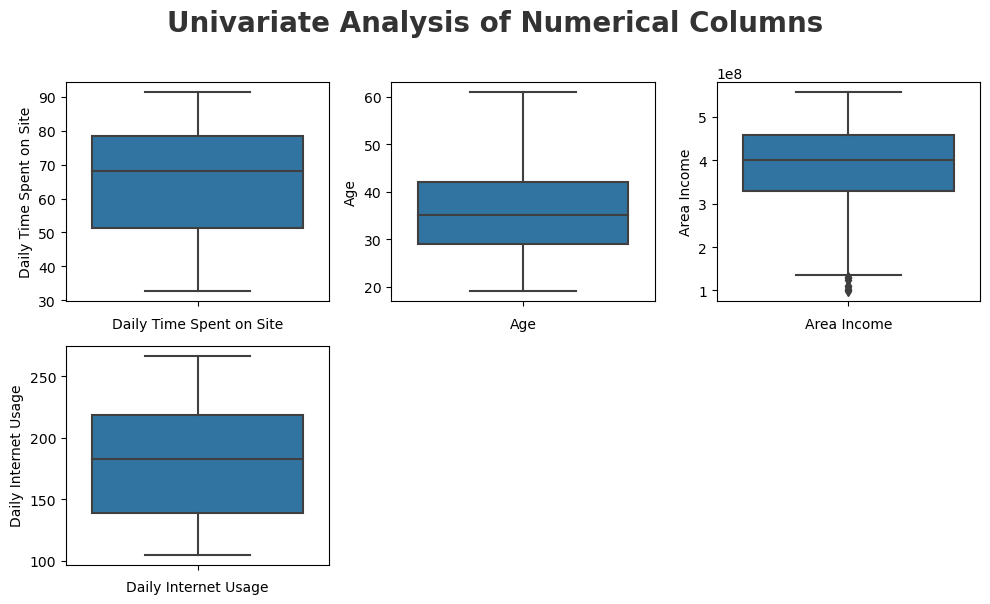

In [70]:
plt.figure(figsize=(10, 6))
plt.suptitle('Univariate Analysis of Numerical Columns', fontsize=20, fontweight='bold', alpha=0.8, y=1.)
for i, col in enumerate(nums):
    plt.subplot(2, 3, i+1)
    sns.boxplot(y=df_eda[col])
    plt.xlabel(col)
plt.tight_layout()
plt.show()

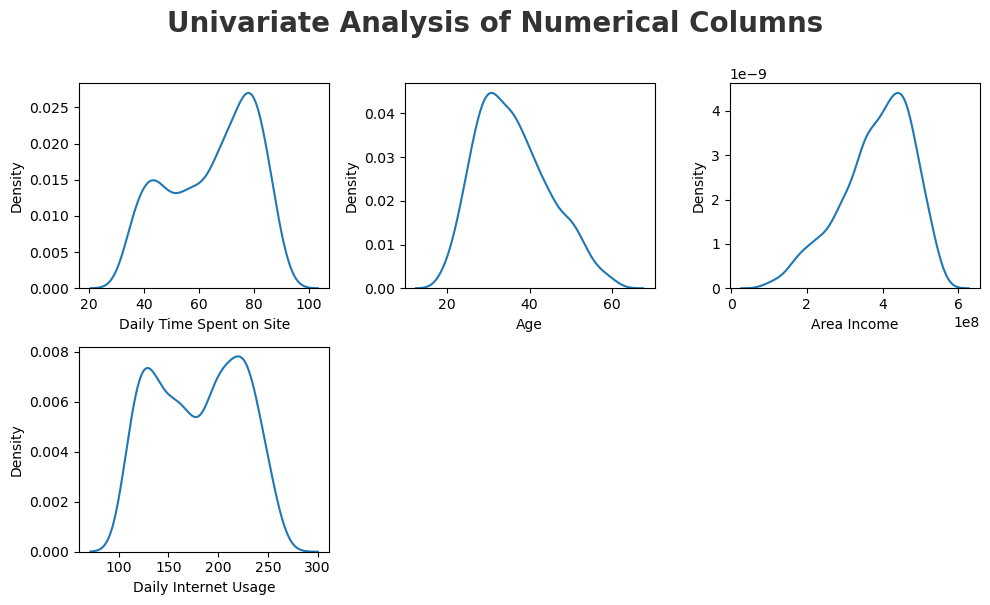

In [71]:
plt.figure(figsize=(10, 6))
plt.suptitle('Univariate Analysis of Numerical Columns', fontsize=20, fontweight='bold', alpha=0.8, y=1.)
for i, col in enumerate(nums):
    plt.subplot(2, 3, i+1)
    sns.kdeplot(x=df_eda[col])
    plt.xlabel(col)
plt.tight_layout()
plt.show()

- **Daily Time Spent on Site:** Rata-rata waktu yang dihabiskan harian di situs adalah sekitar 64.93 menit, dengan standar deviasi sekitar 15.84 menit. Waktu minimum yang dihabiskan adalah 32.60 menit dan maksimumnya adalah 91.43 menit.
- **Age:** Rata-rata usia responden adalah sekitar 36 tahun, dengan standar deviasi sekitar 8.79 tahun. Usia minimum adalah 19 tahun dan maksimumnya adalah 61 tahun.
- **Area Income:** Rata-rata pendapatan area responden adalah sekitar 384,864,700, dengan standar deviasi sekitar 94,079,990. Pendapatan area minimum adalah 97,975,500 dan maksimumnya adalah 556,393,600.
- **Daily Internet Usage:** Rata-rata penggunaan internet harian adalah sekitar 179.86 MB, dengan standar deviasi sekitar 43.87 MB. Penggunaan internet harian minimum adalah 104.78 MB dan maksimumnya adalah 267.01 MB.

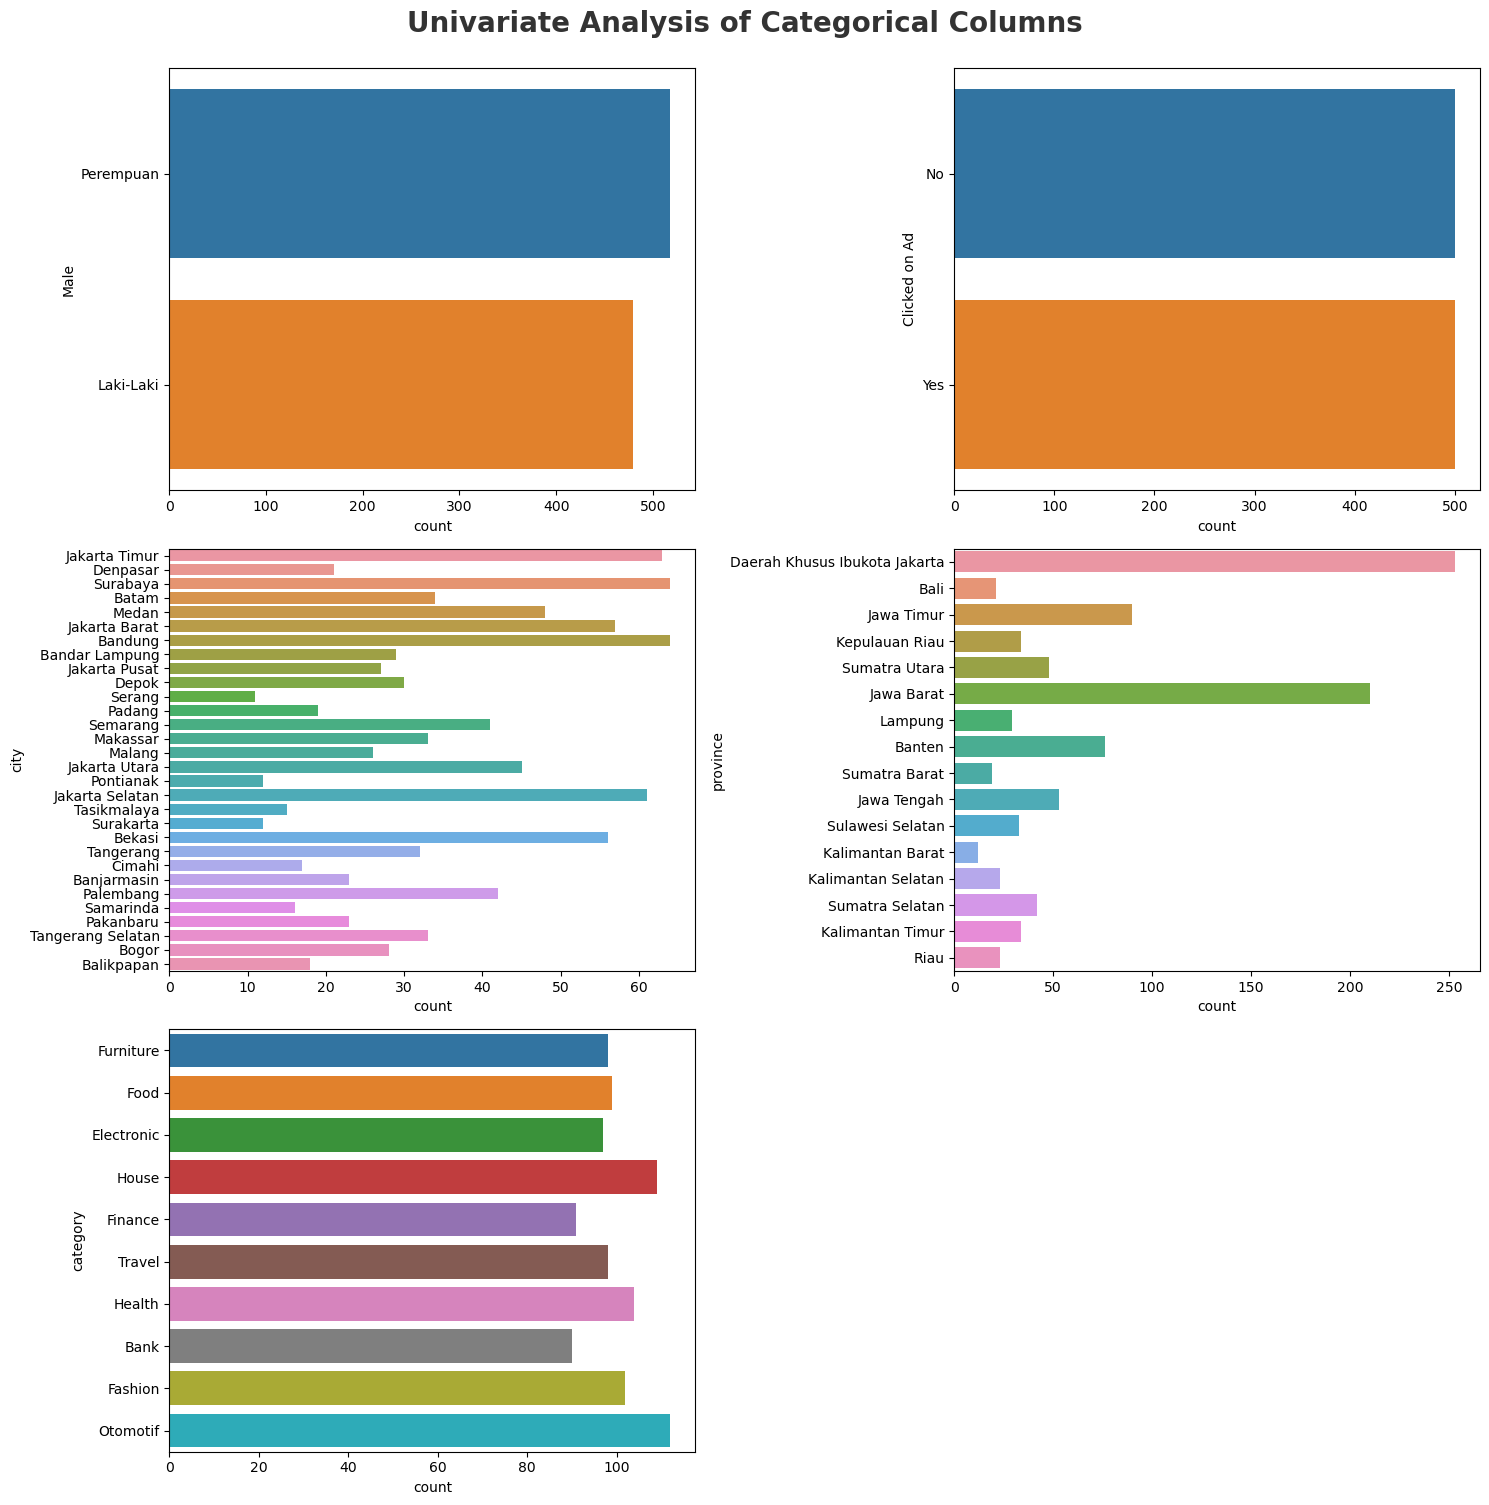

In [72]:
plt.figure(figsize=(15, 15))
plt.suptitle('Univariate Analysis of Categorical Columns', fontsize=20, fontweight='bold', alpha=0.8, y=1.)
for i in range(0, len(cats)):
    plt.subplot(3,2,i+1)
    sns.countplot(y=df_eda[cats[i]], orient = 'h')
    plt.tight_layout()

plt.tight_layout()
plt.show()

- **Male (Jenis Kelamin):** Terdapat 997 entri dalam kolom ini, dengan 2 nilai unik yaitu "Perempuan" dan "Laki-laki". Nilai yang paling sering muncul (mode) adalah "Perempuan" dengan frekuensi 518.
- **Clicked on Ad (Klik pada Iklan):** Terdapat 1000 entri dalam kolom ini, dengan 2 nilai unik yaitu "Yes" dan "No". Nilai yang paling sering muncul adalah "No" dengan frekuensi 500.
- **City (Kota):** Terdapat 1000 entri dalam kolom ini, dengan 30 nilai unik yang mewakili nama-nama kota. Kota "Surabaya" adalah yang paling sering muncul dengan frekuensi 64.
- **Province (Provinsi):** Terdapat 1000 entri dalam kolom ini, dengan 16 nilai unik yang mewakili nama-nama provinsi. Provinsi "Daerah Khusus Ibukota Jakarta" adalah yang paling sering muncul dengan frekuensi 253.
- **Category (Kategori):** Terdapat 1000 entri dalam kolom ini, dengan 10 nilai unik yang mewakili kategori-kategori tertentu. Kategori "Otomotif" adalah yang paling sering muncul dengan frekuensi 112.

### Bivariate Analysis

In [73]:
target = df_eda.groupby('Clicked on Ad')['Daily Time Spent on Site', 'Age', 'Area Income', 'Daily Internet Usage'].agg(['mean','median'])
target

Daily Time Spent on Site             Age          Area Income  \
                                  mean  median    mean median          mean   
Clicked on Ad                                                                 
No                           76.787805  77.615  31.684   31.0  4.299090e+08   
Yes                          53.143111  51.500  40.334   40.0  3.400933e+08   

                           Daily Internet Usage          
                    median                 mean  median  
Clicked on Ad                                            
No             436334990.0           214.595233  216.50  
Yes            344980090.0           145.342077  138.79

#### Numerical Vs Target

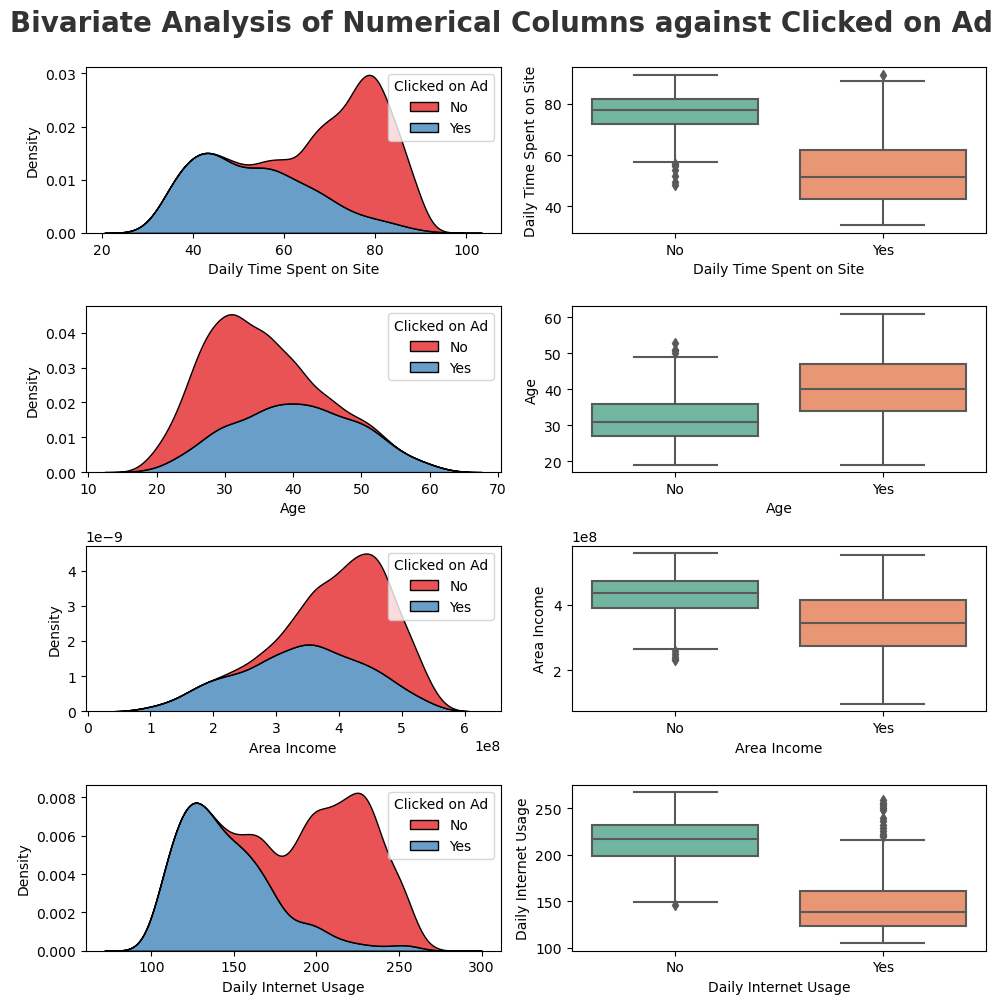

In [74]:
plt.figure(figsize=(10, 10))
plt.suptitle('Bivariate Analysis of Numerical Columns against Clicked on Ad', fontsize=20, fontweight='bold', alpha=0.8, y=1.)

# Plot KDE dan Box plot untuk setiap kolom numerikal dengan target 'ProdTaken'
for i, col in enumerate(nums):
    plt.subplot(4, 2, 2*i+1)
    sns.kdeplot(data=df_eda, x=col, hue='Clicked on Ad', fill=True, multiple='stack', palette='Set1')
    plt.xlabel(col)
    
    plt.subplot(4, 2, 2*i+2)
    sns.boxplot(data=df_eda, x='Clicked on Ad', y=col, palette='Set2')
    plt.xlabel(col)
    
plt.tight_layout()
plt.show()

#### Categorical Vs Target

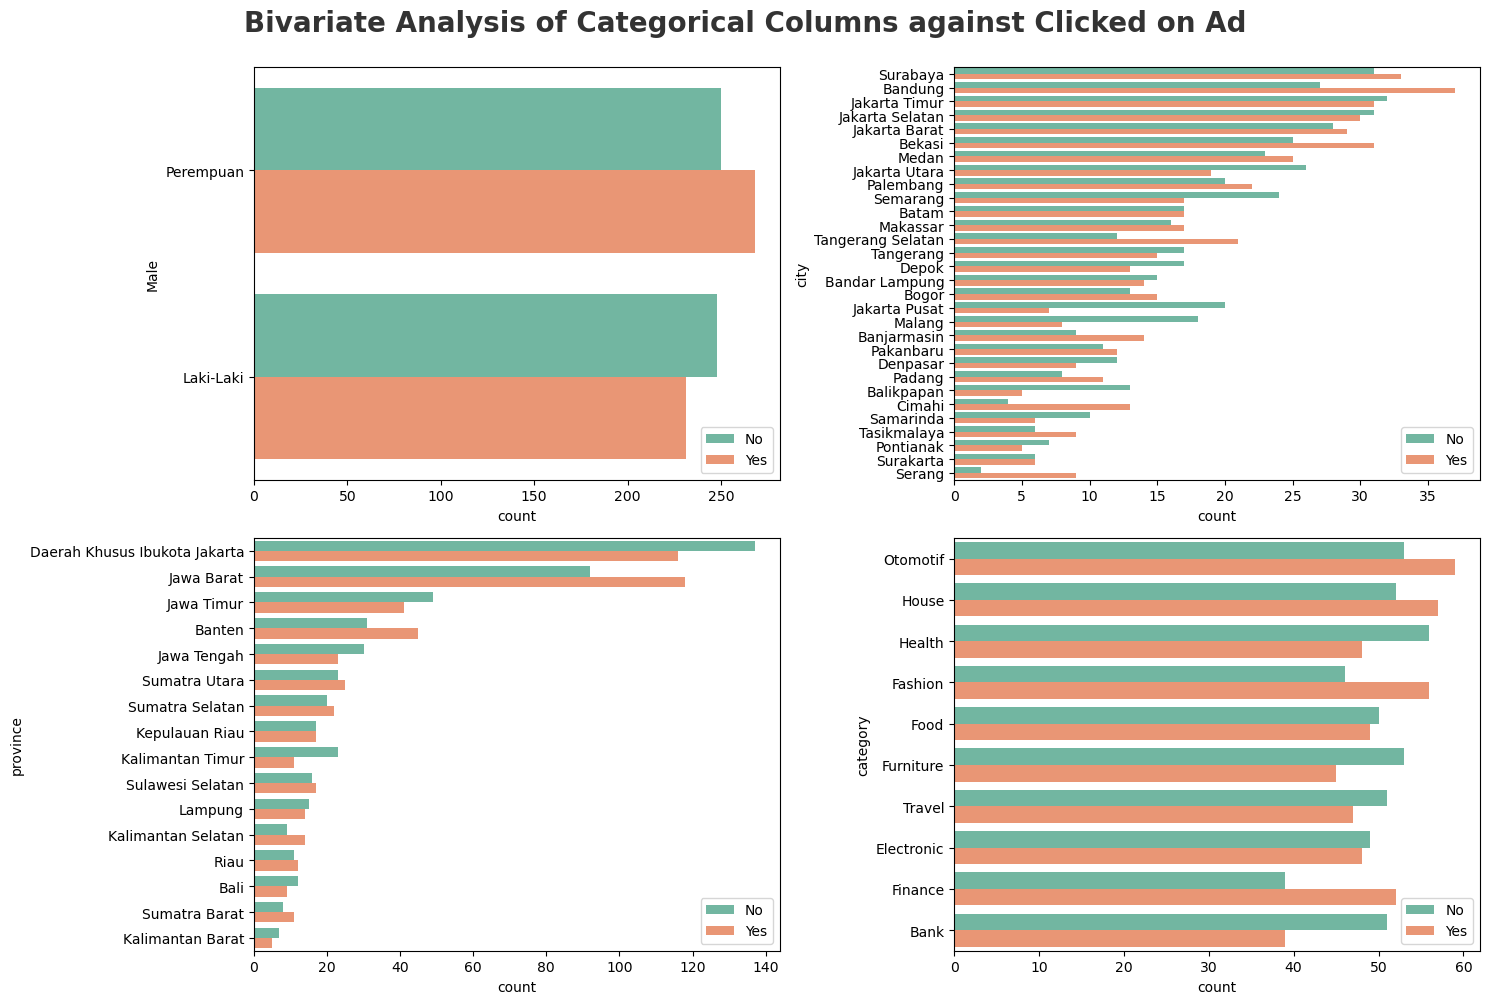

In [75]:
cats = ['Male', 'city', 'province', 'category']

plt.figure(figsize=(15, 10))
plt.suptitle('Bivariate Analysis of Categorical Columns against Clicked on Ad', fontsize=20, fontweight='bold', alpha=0.8, y=1.)

for i in range(0, len(cats)):
    plt.subplot(2, 2, i+1)
    sorted_vals = df_eda[cats[i]].value_counts().index
    ax = sns.countplot(y=df_eda[cats[i]], hue=df_eda['Clicked on Ad'], order=sorted_vals, palette='Set2')
    
    plt.legend(['No', 'Yes'])

plt.tight_layout()
plt.show()


#### Pairplot

<Figure size 1000x1000 with 0 Axes>

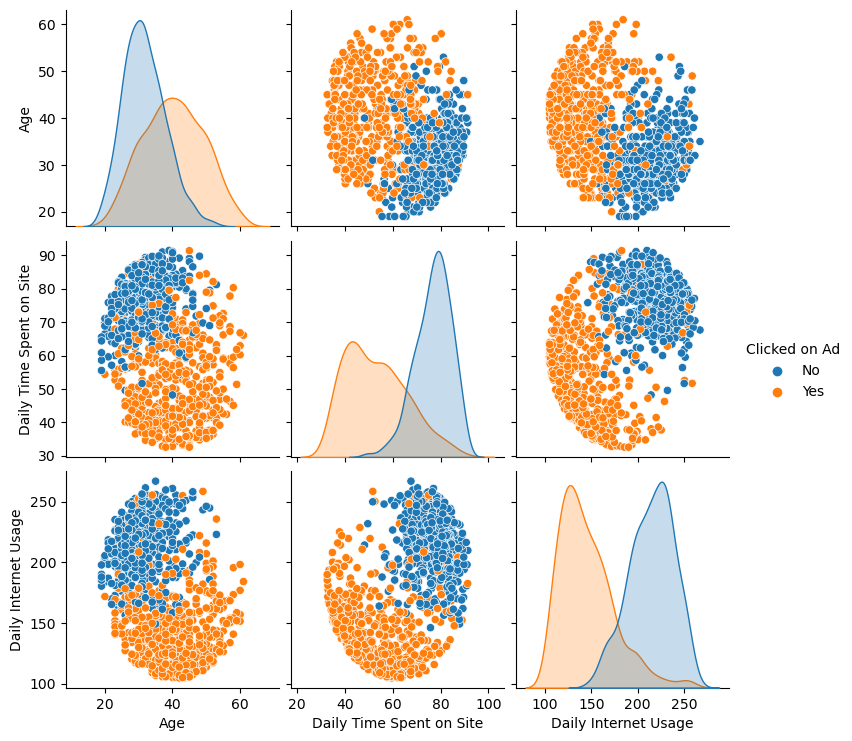

In [76]:
plt.figure(figsize = (10,10))
sns.pairplot(df_eda[['Age','Daily Time Spent on Site','Daily Internet Usage','Clicked on Ad']], diag_kind='kde',hue='Clicked on Ad')
plt.show()

### Multivariate Analysis

<Axes: >

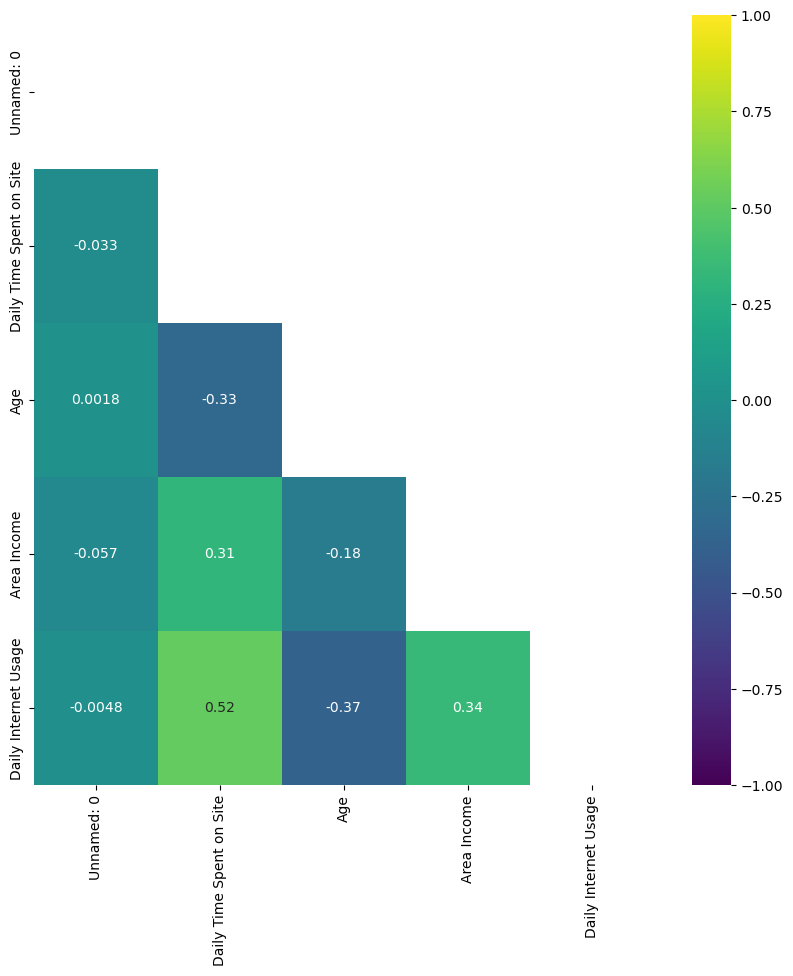

In [77]:
plt.figure(figsize=(10,10))
mask = np.triu(np.ones_like(df_eda.corr(), dtype=bool))
sns.heatmap(df_eda.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='viridis')

- Terdapat korelasi positif yang signifikan antara Daily Internet Usage dan Daily Time Spent on Site.
- Age memiliki korelasi negatif dengan Daily Time Spent on Site, Area Income, dan Daily Internet Usage.
- Area Income memiliki korelasi positif dengan Daily Time Spent on Site dan Daily Internet Usage, dan korelasi negatif dengan age.

# Data Preprocessing